# <center>Universal Language Model Fine-tuning for Text Classification</center>
## <center>NLP Sentimental Analysis on Twitter US Airlines Dataset</center>
### <center>By Ahmad Abboud</center>




1- Abstract
========

Training on inductive transfer has significantly influenced computer vision, but current NLP methods often need task-specific modifications and training from scratch. This notebook discusses the performance of Universal Language Model Fine-tuning (ULMFiT) [1], and efficient transfer learning approach that can be applied to any NLP function, and implementing techniques that are essential to fine-tune a language model. Further, empirical results had been introduced after applying ULMFit for NLP sentimental analysis on Twitter US airlines dataset.

2- Introduction
============

Taking a view of the advantages of pretraining we would be able to do better than initializing arbitrarily the remaining parameters of our models. However, finetuning inductive transfer was ineffective for NLP. Language model (LM) fine-tuning requires millions of in-domain documents to achieve good results, which significantly limits its applicability. Universal Language Model Fine-tuning (ULMFiT) solves these issues and facilitates stable, inductive learning transfers for any NLP function.

3- Model Description
=================

The model used is the state-of-the-art language model AWD-LSTM \[2\], a
standard LSTM with various tuned dropout hyper-parameters (with no
input, short-cut links, or other sophisticated additions).

ULMFiT consists of three stages (Figure 1):

> a\) The LM is trained on a **general-domain** corpus to capture
> general features of the language in different layers.
>
> b\) The full LM is **fine-tuned** on target task data using
> discriminative fine-tuning ('Discr') and slanted triangular learning
> rates (STLR) to learn task-specific features.
>
> c\) The classifier is fine-tuned on the target task using **gradual
> unfreezing**, 'Discr', and STLR to preserve low-level representations
> and adapt high-level ones (shaded: unfreezing stages; black: frozen).

<img src="data/images/ULMFit.png" alt="Figure 1. ULMFiT Model Structure (source [1])s" title="ULMFiT Model Structure" />
<i> Figure 1. ULMFiT Model Structure (source [1])</i>


   a) General-domain LM pretraining 
-----------------------------

The model was pre-trained using Wikitext-103 which is consisting of
28,595 preprocessed Wikipedia documents and 103 million words [2].



   b) Target task LM fine-tuning 
--------------------------

Regardless of how complex the general-domain data used for pre-training is, the target task data would typically come from a different source. Therefore, we fine-tune the language model on target task results. This stage converges more quickly, provided a pre-trained general-domain LM, as it only needs to adjust to the idiosyncrasies of the target data, and it enables us to train a robust language model even for small datasets.


### i- Discriminative fine-tuning

Because different layers’ capture various information types, they should be fine-tuned to a different degree. Instead of using the same learning rate for all layers of the model, Discriminative fine-tuning allows one to apply specific learning levels to each layer. 
It was empirically found that it performed well to select the last layer's Alpha^L learning rate first by fine-tuning only the last layer and using Alpha^(L-1) = (Alpha^L)/2.6 as the lesser layer learning rate. For L, the order of the layer in the model.


### ii- Slanted triangular learning rates

To adjust its parameters to task-specific features, at the beginning of the training, make the model converge quickly into an acceptable region of the parameter space, and then refine its parameters. Slanted triangular learning rates (STLR), first increase the learning rate linearly and then decay it linearly. Finally, the learning rate at the stiffest slop will be chosen.

   c) Target task classifier fine-tuning
----------------------------------

The pre-trained language model with two additional linear blocks was augmented to fine-tune the classifier. Following common practice for Computer Vision (CV) classifiers, each block uses batch normalization and dropout, with intermediate layer ReLU activations, and a Softmax activation that outputs a probability distribution at the last layer over target classes. Remember that the only parameters learned from scratch are the parameters in these task-specific classifier strata. The first linear layer takes the last hidden layer being pooled as the input state.


4-  Application
===========

   a.  Dataset Description
-------------------

The dataset is published on [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) [3], and it analyzes how travellers in February 2015 expressed their feelings on Twitter. It contains 14640 records, which was semantically analysed. 

   b. Problem Description
-------------------

Sentiment analysis of the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets. The problem under our interest is to create a classification model that can identify the sentiment of the text written by the client as positive, negative or neutral.  

   c.  Exploratory Analysis
--------------------





In [2]:
# prepare the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# import necessary libraries
import numpy as np
from fastai.text import *
from pathlib import Path

#### Preparing and Download the data

First let's download the dataset we are going to study. 

In [4]:
# View current working directory
print(f"Current directory: {Path.cwd()}")
print(f"Home directory: {Path.home()}")
path=Path.cwd()


Current directory: C:\Users\AHB\Desktop\Fellow AI\Challenge
Home directory: C:\Users\AHB


In [5]:
# Set the path to the data folder
path=path/'data'
path.ls()

[WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/data_clas.pkl'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/data_lm.pkl'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/data_save.pkl'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/images'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/models'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/Tweets.csv'),
 WindowsPath('C:/Users/AHB/Desktop/Fellow AI/Challenge/data/Tweets_org.csv')]

In [11]:
# Download Dataset
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('crowdflower/twitter-airline-sentiment', path=path, unzip=True)

It only contains one csv file, let's have a look at it.

In [13]:
#Prepare Dataframe
df_org = pd.read_csv(path/'Tweets.csv')
df_org.rename(columns={'airline_sentiment':'label'},inplace=True)               
df=df_org[['label','text']]
np.random.seed(2020)
df['is_valid']=np.random.choice([True, False], len(df_org), p=[0.9,0.1 ]) # Seperate 10% for test
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,text,is_valid
0,neutral,@VirginAmerica What @dhepburn said.,False
1,positive,@VirginAmerica plus you've added commercials t...,True
2,neutral,@VirginAmerica I didn't today... Must mean I n...,True
3,negative,@VirginAmerica it's really aggressive to blast...,True
4,negative,@VirginAmerica and it's a really big bad thing...,True


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     14640 non-null  object
 1   text      14640 non-null  object
 2   is_valid  14640 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 243.2+ KB


In [14]:
# Save to clean version CSV
df[['label','text','is_valid']].to_csv(path/'Tweets.csv',index=False)

In [16]:
#Show the first text item 
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

### Data Visualization

To have an idea about the distribution of the sentiment labels we will present the frequency distribution over the pie chart and histograms.

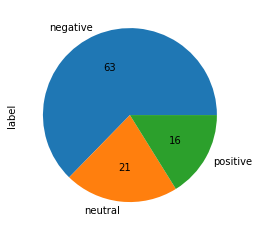

In [20]:
import seaborn as sns
df.label.value_counts().plot(kind='pie',autopct='%1.0f')

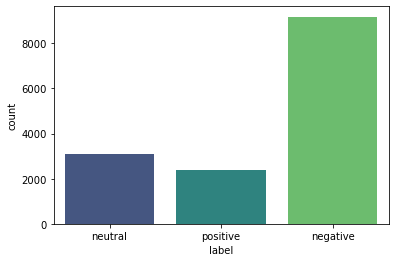

In [21]:
# Sentiment distribution
sns.countplot(x='label',data=df,palette='viridis')

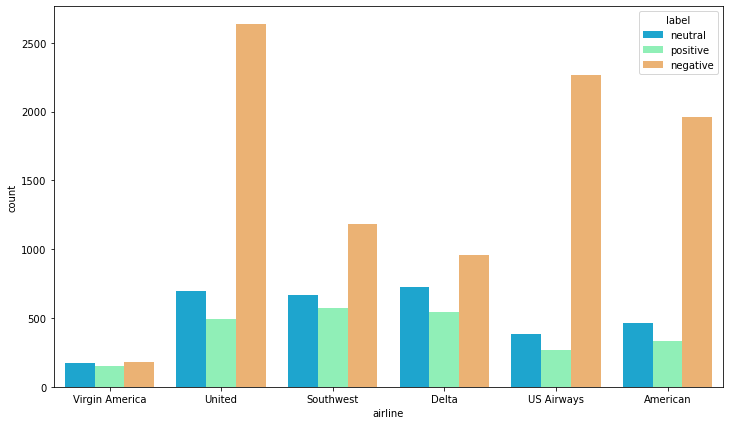

In [22]:
#sentiment distribution over airelines 
plt.figure(figsize=(12,7))
sns.countplot(x='airline',hue='label',data=df_org,palette='rainbow')

   d.  Feature Selection
-----------------

Feature selection is the process of selecting what we think is worthwhile in our documents, and what can be ignored. Rejected features are those that act like noise, thus when fed to the model with the training set, the classification accuracy will decrease.
In most NLP literature work, stop words, punctuations and non-formal vocabs are deprecated from the training set. Furthermore, most work applies word stemming to return the used words to their lemma. However, we believe that all the words in the text field are important and there no reason to deprecate them. Besides, this notebook takes into consideration only the text field as the dependent variable where we leave the process of exploring the effectiveness of other features for future optimization.


   e.  Data Preprocessing
------------------


The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, we can further:

-  take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance




###    i-Creating Data Bunches

A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.


In [26]:
# selecting bunch size depends on the memory size of your PC
bs=48

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our DataBunch object.

In [9]:
data_lm = (TextList.from_csv(path, 'Tweets.csv', cols='text') 
            .split_by_rand_pct(0.1,seed=2020)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

In [10]:
#Save DataBunch object
data_lm.save('data_lm.pkl')

In [11]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [12]:
# Lets have a look at the first item of the training set
data_lm.train_ds[0][0]

Text xxbos @virginamerica xxmaj what xxunk said .

But the underlying data is all numbers

In [13]:
data_lm.train_ds[0][0].data[:10]

array([  2, 104,   5,  71,   0, 254,   9], dtype=int64)

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [14]:
data_lm.show_batch()

idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,". xxmaj do n't worry , i 'll keep trying :) xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk xxbos @virginamerica xxmaj nice ,"
2,to be held xxunk for their error xxbos @united a xxmaj tourist xxmaj wonder : xxmaj super xxmaj xxunk and xxmaj xxunk of the xxmaj century at xxmaj french and xxup xxunk xxunk : http : / / t.co / xxunk xxbos @united xxmaj yeah sorry but there 's always a problem with xxmaj united . xxmaj and you have an international reputation for having problems . xxbos @united y
3,"@united that is not in line with your responses here . xxmaj and now i 'm waiting until tomorrow morning because all the flights are overbooked . xxbos @united i took the exact same aircraft in to xxup lax 3 days ago . xxmaj it fit , no problem . xxmaj the agent today told some nonsense about a policy change xxbos @united your helpful agents in xxmaj club helped"
4,to start daily # xxup xxunk - xxup xxunk flights from # xxmaj newark to # xxmaj milan # xxmaj xxunk replacing # xxup b767 - xxup 400er on xxup xxunk instead xxup xxunk # avgeek xxbos @united to start daily # xxup xxunk - xxup xxunk flights from # xxmaj newark to # xxmaj frankfurt xxunk replacing # xxup b767 - xxup 400er on xxup xxunk # avgeek xxbos


### Tokenization

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [15]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 'a',
 '?',
 '/',
 'you',
 ',',
 'for']

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

   f.  Modelling
--------

###    i-   Pre-trained Learning



We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [16]:
# Slanted triangular learning rates (STLR), which first linearly increases the learning rate and then linearly decays it
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


###     ii- Learning rate selection

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


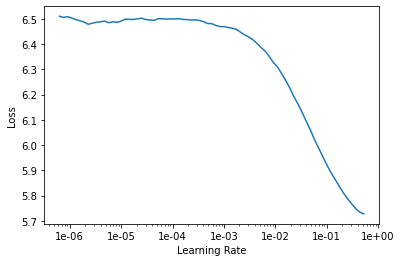

In [18]:
learn.recorder.plot(skip_end=15)

###    iii-  Fine-tuning

In [19]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # lr should be 4*1e-2 at the stiffest slope
#The momentum is the first beta in Adam (or the momentum in SGD/RMSProp). When you pass along (0.8,0.7) it means going from 0.8 to0.7 during the warmup then from 0.8 to 0.7 in the annealing, but it only changes the first beta in Adam
#fit_one_cycle equivalent to the Adam optimizer’s (beta_2, beta_1) (notice the order) parameters, where beta_1 is the decay rate for the first moment, and beta_2 for the second

epoch,train_loss,valid_loss,accuracy,time
0,4.357775,3.888268,0.262906,26:54


In [20]:
learn.save('fit_head')

In [21]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.852342,3.770110,0.278111,29:29
1,3.737838,3.663381,0.293290,29:33
2,3.590960,3.587544,0.298187,29:50
3,3.417320,3.550152,0.304221,30:07
4,3.256868,3.542388,0.304951,29:51
5,3.068433,3.556983,0.303923,29:29
6,2.915403,3.581319,0.305547,29:28
7,2.772245,3.611358,0.303869,29:31
8,2.688982,3.627949,0.303653,30:06
9,2.646860,3.636186,0.303328,29:17


In [24]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [25]:
learn.load('fine_tuned');

In [26]:
TEXT = "I liked this airline because"
N_WORDS = 40
N_SENTENCES = 2

In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this airline because of your lack of communication and concern xxbos @southwestair On hold for over 2 hours and still no email address from rep i 'm wondering . Thanks xxbos @united Thanks for the reply ! xxbos @southwestair
I liked this airline because of you , but your marketing practices do n't work . It causes a shock in your balance . xxbos @southwestair why do n't you keep letting people wait on hold to hold wait . # 👍 xxbos @southwestair


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [28]:
learn.save_encoder('fine_tuned_enc')

###    iv-  Transfer Learning Classifier Model

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [52]:
data_clas=TextClasDataBunch.from_csv(path, 'Tweets.csv',vocab=data_lm.vocab)


In [53]:
data_clas.save('data_clas.pkl')

In [27]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [28]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup xxunk xxunk / 9 xxup xxunk - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup xxunk - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
xxbos @americanair xxmaj took a flight yesterday xxunk xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative
"xxbos @united xxmaj cancelled xxmaj flights flt from xxup ewr . "" xxmaj no xxunk . xxmaj tells wife & & 4 yr old to "" get to xxup ny to catch @aircanada "" to xxup yyz ! xxmaj good # customerservice is dead .",negative


We can then create a model to classify those reviews and load the encoder we saved before.

In [29]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [57]:
#Show the learner structure 
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @americanair seriously , pls pls bring more people up to help us ! xxmaj there are still flights to xxup ord frm xxup dfw and i want in http : / / t.co / xxunk,xxbos @united it 's cool . i did n't need to go to work today . xxmaj or get home to make sure my house is ok in the xxunk wind chill .,xxbos @southwestair you 're giving everyone tix for # destinationdragons except for me and it 's during my birthday xxrep 4 !,xxbos @jetblue great smooth flight too ! 👏 👍,xxbos @jetblue flight xxunk xxup den to xxup jfk already 2hrs delayed . xxmaj any idea how that might change again due to weather forecast etc ?
y: CategoryList
negative,neutral,negative,positive,negative
Path: C:\Users\AHB\Desktop\Fellow AI\Challenge\data;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways i ca nt get anyone on the phone to help with award travel . xxmaj purchased extra miles and 10 minutes xxmaj late xxmaj flightr th

In [30]:
# Transfer learned encoder from previous language model
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @americanair seriously , pls pls bring more people up to help us ! xxmaj there are still flights to xxup ord frm xxup dfw and i want in http : / / t.co / xxunk,xxbos @united it 's cool . i did n't need to go to work today . xxmaj or get home to make sure my house is ok in the xxunk wind chill .,xxbos @southwestair you 're giving everyone tix for # destinationdragons except for me and it 's during my birthday xxrep 4 !,xxbos @jetblue great smooth flight too ! 👏 👍,xxbos @jetblue flight xxunk xxup den to xxup jfk already 2hrs delayed . xxmaj any idea how that might change again due to weather forecast etc ?
y: CategoryList
negative,neutral,negative,positive,negative
Path: C:\Users\AHB\Desktop\Fellow AI\Challenge\data;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways i ca nt get anyone on the phone to help with award travel . xxmaj purchased extra miles and 10 minutes xxmaj late xxmaj flightr th

###    v-   Learning rate selection

In [59]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


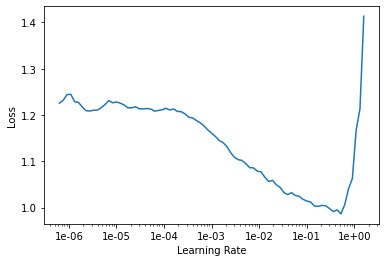

In [60]:
learn.recorder.plot()

###    vi-  Fine-tuning

In [61]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.704763,0.539039,0.777057,26:07


In [62]:
learn.save('first')

In [63]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @americanair seriously , pls pls bring more people up to help us ! xxmaj there are still flights to xxup ord frm xxup dfw and i want in http : / / t.co / xxunk,xxbos @united it 's cool . i did n't need to go to work today . xxmaj or get home to make sure my house is ok in the xxunk wind chill .,xxbos @southwestair you 're giving everyone tix for # destinationdragons except for me and it 's during my birthday xxrep 4 !,xxbos @jetblue great smooth flight too ! 👏 👍,xxbos @jetblue flight xxunk xxup den to xxup jfk already 2hrs delayed . xxmaj any idea how that might change again due to weather forecast etc ?
y: CategoryList
negative,neutral,negative,positive,negative
Path: C:\Users\AHB\Desktop\Fellow AI\Challenge\data;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways i ca nt get anyone on the phone to help with award travel . xxmaj purchased extra miles and 10 minutes xxmaj late xxmaj flightr th

In [64]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))   #?? why 1e-2/(2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.607261,0.484481,0.803346,29:00


In [65]:
learn.save('second')

In [66]:
learn.load('second');

In [67]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.608567,0.450027,0.817002,30:55


In [68]:
learn.save('third')

In [31]:
learn.load('third');

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.484002,0.439225,0.822124,32:14
1,0.442841,0.443872,0.824855,28:39


In [33]:
learn.save('Fourth')

In [36]:
learn.load('Fourth');

###    vii-  Prediction and Results

It is clear that the losses plunged just after the second epoch and the  accuracy reached 0.824. 

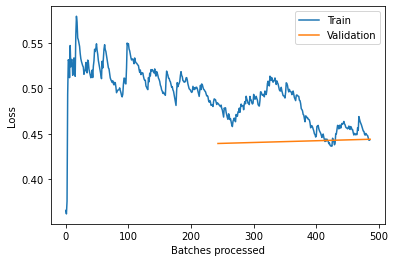

In [37]:
learn.recorder.plot_losses()

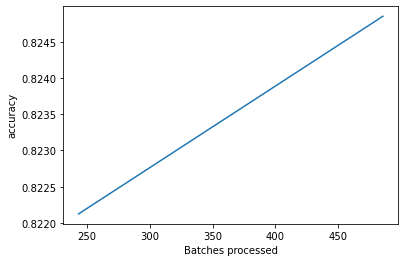

In [38]:
learn.recorder.plot_metrics()

In [71]:
learn.predict("I really loved that airline, it was awesome!")

C:\ProgramData\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category positive, tensor(2), tensor([0.0043, 0.0023, 0.9934]))

In [39]:
# Prepare Interpreter
interp = ClassificationInterpretation.from_learner(learn)

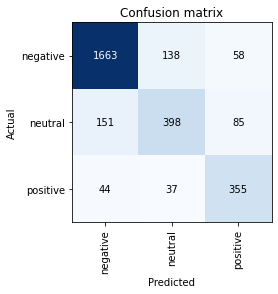

In [40]:
# Confusion Matrix
interp.plot_confusion_matrix()

5-  Conclusion
==========

By the conclusion, we have applied a ULMFiT on classification job for US airlines sentimental analysis where the obtained results are promising. Using transfer learning and AWD-LSTM pre-trained network we reach an accuracy of more than 82% with few learning epochs, which is pretty good compared to the literature results. Moreover, the results can be improved by pre-train the model with text chats from social networks e.g. Twitter, Facebook, where nonformal language can more accurately fit this dataset compared to Wikitext-103, which in most cases contain a formal and scientific language. Besides, exploring the effect of another independent variable in the dataset could also improve the results especially the field “negativereason” .

6-  References
==========

\[1\] J. Howard and S. Ruder, "Universal language model fine-tuning for
text classification," in *ACL 2018 - 56th Annual Meeting of the
Association for Computational Linguistics, Proceedings of the Conference
(Long Papers)*, 2018. <br>
\[2\] S. Merity, N. S. Keskar, and R. Socher,
"Regularizing and optimizing LSTM language models," in *6th
International Conference on Learning Representations, ICLR 2018 -
Conference Track Proceedings*, 2018. <br>
\[3\] "Twitter US Airline Sentiment
\| Kaggle." \[Online\]. Available:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment.
\[Accessed: 13-Jul-2020\].
